In [2]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [10]:
import numpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from gaussian_system import System, time_matrix, estimate_log_marginal_at

In [11]:
path = Path.cwd().parent / "plots"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots')

In [12]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

In [13]:
t = time_matrix(100, 0.1)
marg_x = multivariate_normal(cov=system.corr_xx(t))
x = marg_x.rvs()
x

array([-6.17047754, -6.63008819, -6.7153708 , -7.47221843, -7.50263742,
       -7.74067012, -7.55929564, -7.66091791, -7.39169574, -7.19626461,
       -7.12027098, -6.73713254, -7.00544745, -7.31532323, -6.78372547,
       -7.45597042, -7.42456686, -7.47465598, -7.52399073, -7.62846136,
       -7.15848305, -6.975513  , -7.28620811, -7.20681207, -7.26988998,
       -7.2419503 , -7.02347025, -7.12442615, -6.86785928, -6.69140782,
       -6.89896432, -6.74003495, -7.13476612, -7.14990964, -7.1584644 ,
       -7.00404447, -7.44991951, -7.8341791 , -7.72325952, -8.19998643,
       -8.08834108, -8.22122236, -8.10325425, -8.06830295, -8.12033045,
       -8.15312911, -7.86490454, -7.96490543, -8.06156676, -7.99842611,
       -8.17975851, -7.80161249, -7.5506691 , -7.37364009, -7.47669795,
       -7.83803108, -8.17240522, -8.07693025, -7.62917144, -7.91529573,
       -7.46302566, -7.52803745, -7.98497347, -8.27535364, -8.16161967,
       -8.33417869, -8.31691636, -8.02199626, -7.06575976, -6.81

In [14]:
data = pd.Series(estimate_log_marginal_at(x, 100000, system, t).squeeze())

(0.038394314735814644, -20.84728831392049, 0.022868615885189587)


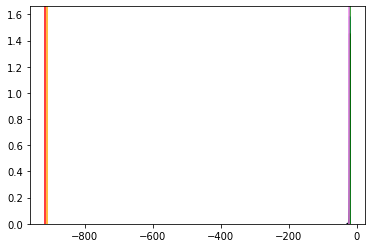

In [19]:
ax = sns.distplot(data)
fitparams = scipy.stats.loggamma.fit(data)
print(fitparams)
plot_range = numpy.linspace(data.min(), data.max(), 200)
plt.plot(plot_range, scipy.stats.loggamma.pdf(plot_range, *fitparams), "black")
(shape_param, offset, scale) = fitparams

plt.axvline(x=offset/scale + numpy.log(shape_param), color='red')
plt.axvline(x=offset/scale, color='orange')
plt.axvline(x=scipy.special.logsumexp(data, b=1/len(data)), color='green')
plt.axvline(x=data.mean(), color='violet')

In [124]:
data

NameError: name 'data' is not defined

In [75]:
marg_x.logpdf(x), logsumexp(data.log_likelihood, b=1/len(data.log_likelihood))

(-21.56338201036904, -21.537688162983294)

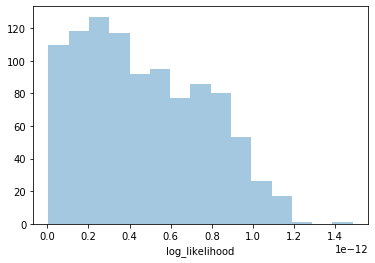

In [46]:
sns.distplot(numpy.exp(data['log_likelihood']), kde=False)

In [20]:
stochastic_data = pd.read_json(path / "log_likelihood" / "data.json")
stochastic_data

,duration,log_likelihood,sampled_from
0,0.000000,-3.092278,posterior
1,1.603206,-6.511124,posterior
2,3.206413,-9.687647,posterior
3,4.809619,-12.819024,posterior
4,6.412826,-15.738812,posterior
...,...,...,...
5000495,793.587174,-1379.707082,prior
5000496,795.190381,-1382.654596,prior
5000497,796.793587,-1385.173293,prior
5000498,798.396794,-1389.306492,prior


In [71]:
stochastic_hist = stochastic_data.set_index('duration', append=True)

In [74]:
stochastic_hist.index

MultiIndex([(      0,                0.0),
            (      1, 1.6032064128256511),
            (      2,  3.206412825651302),
            (      3,  4.809619238476954),
            (      4,  6.412825651302605),
            (      5,  8.016032064128257),
            (      6,  9.619238476953909),
            (      7,  11.22244488977956),
            (      8,  12.82565130260521),
            (      9, 14.428857715430862),
            ...
            (5000490,  785.5711422845692),
            (5000491,  787.1743486973949),
            (5000492,  788.7775551102204),
            (5000493,  790.3807615230461),
            (5000494,  791.9839679358718),
            (5000495,  793.5871743486974),
            (5000496,  795.1903807615231),
            (5000497,  796.7935871743488),
            (5000498,  798.3967935871743),
            (5000499,              800.0)],
           names=[None, 'duration'], length=5000500)

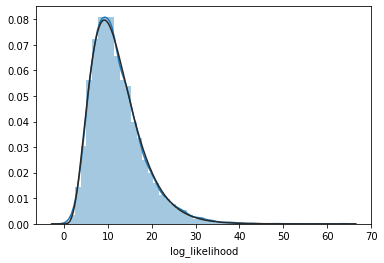

In [22]:
sns.distplot(-stochastic_hist.log_likelihood + stochastic_hist.log_likelihood.max(), fit=scipy.stats.gengamma)

(0.7032857414243779, -1388.6666056230397, 3.557206600454636)


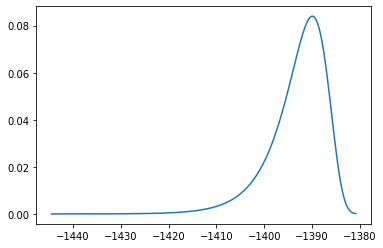

In [23]:
fitparams = scipy.stats.loggamma.fit(stochastic_hist.log_likelihood)
print(fitparams)
plot_range = numpy.linspace(stochastic_hist.log_likelihood.min(), stochastic_hist.log_likelihood.max(), 200)
plt.plot(plot_range, scipy.stats.loggamma.pdf(plot_range, *fitparams))

(0.7032857414243779, -1388.6666056230397, 3.557206600454636)


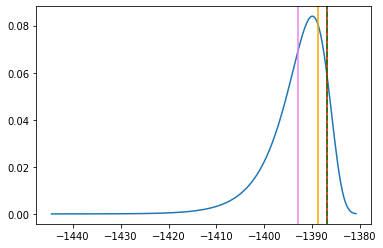

In [36]:
(shape_param, offset, scale) = fitparams
print(fitparams)
plt.plot(plot_range, scipy.stats.loggamma.pdf(plot_range, *fitparams))
plt.axvline(x=offset + numpy.log(scipy.special.gamma(shape_param + scale)/scipy.special.gamma(shape_param)), color='red')
plt.axvline(x=offset, color='orange')
plt.axvline(x=scipy.special.logsumexp(stochastic_hist.log_likelihood, b=1/len(stochastic_hist)), linestyle='--', color='green')
plt.axvline(x=stochastic_hist.log_likelihood.mean(), color='violet')

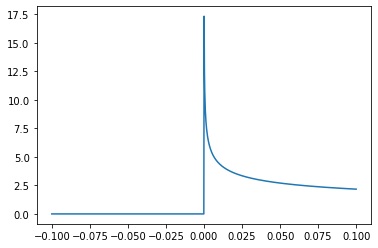

In [63]:
plt.plot(numpy.linspace(-0.1, 0.1, 1000), scipy.stats.gengamma.pdf(numpy.linspace(-0.1, 0.1, 1000)/scale, shape_param, 1))

In [60]:
(offset + numpy.log(scipy.special.gamma(shape_param + scale)/scipy.special.gamma(shape_param))) / scipy.special.logsumexp(stochastic_hist.log_likelihood, b=1/len(stochastic_hist))

0.9999792687123988